In [1]:
%load_ext autoreload
%autoreload 2

from notebook_config import setup_notebook
import matplotlib.pyplot as plt
import numpy as np

setup_notebook()

In [2]:
from datasets.stocks_data_wrapper import StocksDataWrapper
from helpers.data_helper import *
from helpers.plots_helper import *
from helpers.learning_utils import *

In [3]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
print(device)

cuda


### Prepare data

In [5]:
DATA_PATH = '../data/'
FILE_SUFFIX='.txt'

quotation = 'IBM'
price_column = 'Close'
project_label='LinearNN2Classes'

predict_n = 5

In [10]:
data_wrapper = StocksDataWrapper.read_from(file_path=f"{DATA_PATH}{quotation}{FILE_SUFFIX}", thresh_diff=0.005,
                                           compute_features=True, predict_n=predict_n, normalize=True)

data_wrapper.head()

,Date,Open,High,Low,Close,Adjusted,Volume,LowLen,RSI(14),GAP,...,SMA(10),SMA(20),EMA(14),EMA_Diff,SMA(20) - SMA(10),Difference,PercentageDiff,Tendency,NextPrice,Next
0,1962-03-21,0.015428,0.014523,0.015787,0.015429,0.005020,0.003780,0.002525,0.595025,0.000000,...,0.014503,0.013555,0.013679,0.614097,0.394439,0.553595,0.544670,stay,0.014705,higher
1,1962-03-22,0.015334,0.014334,0.015533,0.015051,0.004897,0.003456,0.000000,0.456905,0.001641,...,0.014474,0.013587,0.013637,0.613560,0.394997,0.552214,0.528665,lower,0.014610,stay
2,1962-03-23,0.015113,0.014271,0.015565,0.015177,0.004938,0.002700,0.000000,0.505305,0.000410,...,0.014436,0.013619,0.013618,0.613056,0.395653,0.552076,0.527143,stay,0.014280,lower
3,1962-03-26,0.015207,0.014334,0.015597,0.015162,0.004933,0.001944,0.001263,0.499957,0.000000,...,0.014399,0.013656,0.013600,0.612481,0.396346,0.551593,0.521630,stay,0.013823,lower
4,1962-03-27,0.015113,0.014114,0.014963,0.014516,0.004723,0.005076,0.000842,0.332912,0.001026,...,0.014300,0.013658,0.013496,0.611450,0.397285,0.549730,0.499895,lower,0.013005,lower


In [11]:
data_wrapper['Next'].value_counts()

higher    4980
stay      4932
lower     4881
Name: Next, dtype: int64

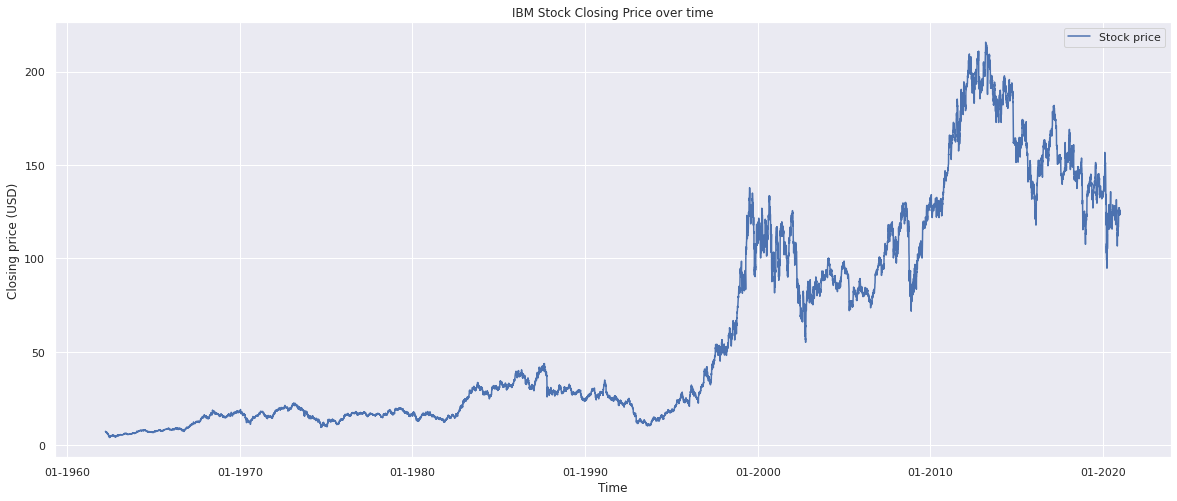

In [12]:
prices = data_wrapper.get_unscaled_data()['Close']
plot_prices(price_series=prices, date_series=data_wrapper['Date'], quotation_name=quotation)
plt.show()

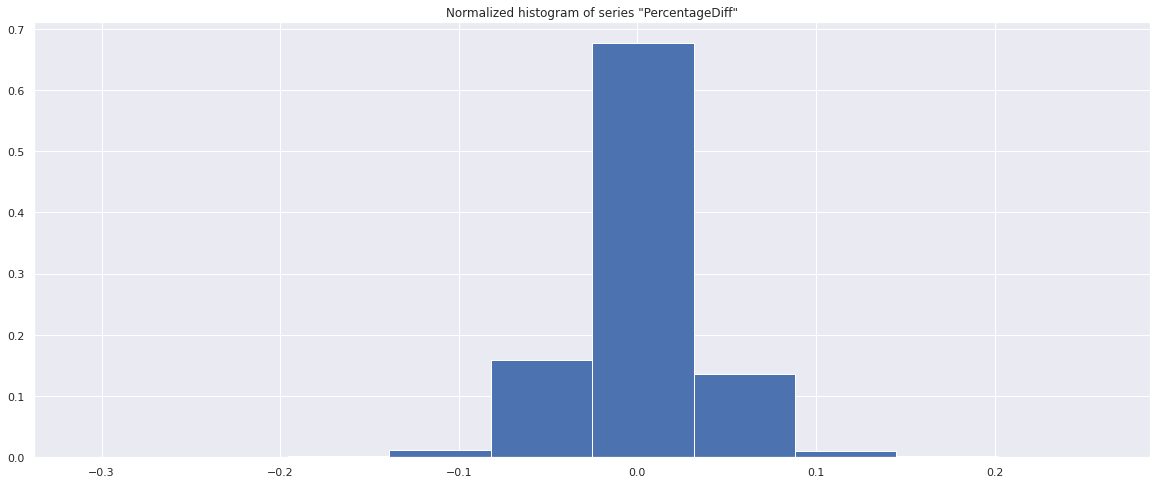

In [13]:
ax = plot_normalized_histogram(data_wrapper.get_unscaled_data()['PercentageDiff'])

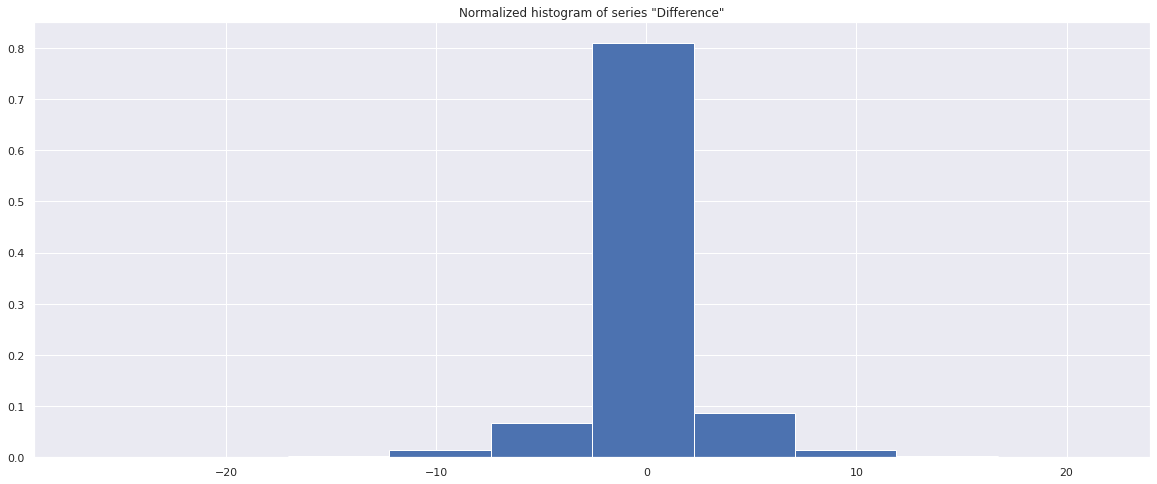

In [14]:
ax = plot_normalized_histogram(data_wrapper.get_unscaled_data()['Difference'])

In [16]:
from torch.utils.data import Dataset
from datasets.torch_datasets import StocksDataset


y_column = 'Next'
data_columns = ['Close', 'Volume', 'MACD_diff', 'RSI(14)', 'PercentageDiff', 'LowLen', 'RSI_diff']

X_train, X_test, y_train, y_test = data_wrapper.get_datasets(n_splits=1, val_size=0.3, 
                                                             y_column='NextPrice', 
                                                             features_list=data_columns)

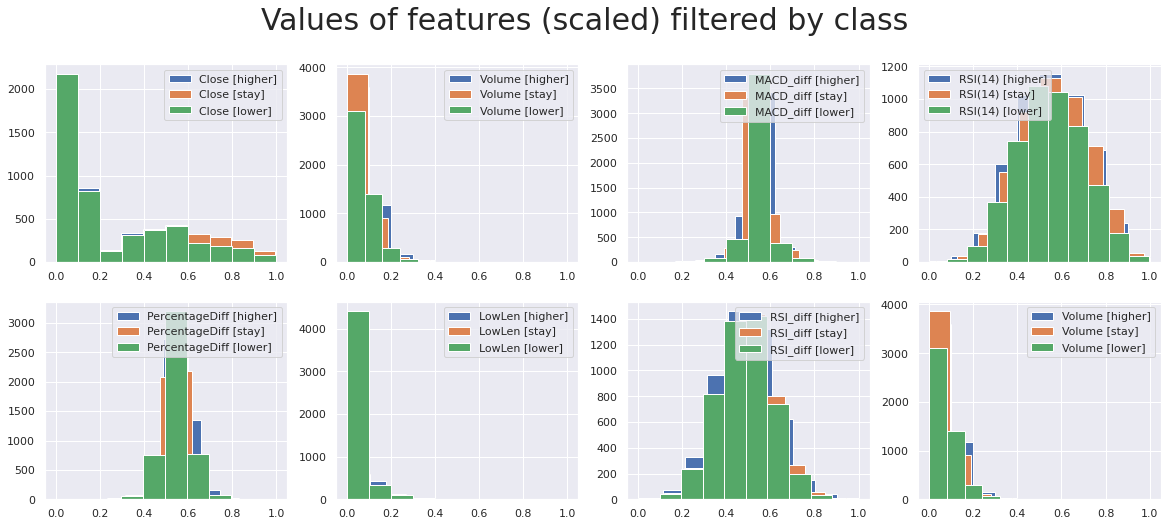

In [19]:
N_COLS = 4
plot_feature_names = data_columns.copy()

if 'Next' in plot_feature_names:
    plot_feature_names.remove('Next')
if 'Volume' in data_wrapper.df.columns.values:
    plot_feature_names.append('Volume')
plot_filtered_class_features(data_wrapper.df, n_cols=N_COLS, feature_names=plot_feature_names, class_column='Next')

plt.show()

In [20]:
from torch.utils.data import DataLoader
train_dataset = StocksDataset(X_train,y_train)
test_dataset = StocksDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)


print(f"Train size : {len(train_dataset)}, test_size : {len(test_dataset)}")

Train size : 10355, test_size : 4438


### Model

In [16]:
from models.pytorch_linear_model import LinearModel
from trainers.pytorch_regression_trainer import PytorchClassificationTrainer

import torch.nn as nn

config = dict(
    lr=1e-5,
    loss=nn.MSELoss,
    n_epochs=5,
    optimizer=torch.optim.Adam,
)
model = LinearModel(config, input_dim=X_train.shape[1], output_dim=1, device=device)
print(model)


trainer = PytorchRegressionTrainer(model, device=device, use_wandb=True, project_label=project_label)
trainer.train(dataloader=train_dataloader)

  0%|                                                                                                                   | 0/50 [00:03<?, ?it/s]


RuntimeError: Expected object of scalar type Long but got scalar type Float for argument #2 'target' in call to _thnn_nll_loss_forward

In [ ]:
predictions, labels = predict(model, test_dataloader, device)

In [ ]:
metrics_dict = compute_metrics(model, test_dataloader, device)

print(metrics_dict)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

print(f"Test accuracy : {100 * metrics_dict['accuracy']:.2f}%")

class_labels = ['lower', 'higher']

ax = plot_heatmap(labels, predictions, class_labels, normalize='all')

In [ ]:
ax = plot_roc_auc_curve(labels, predictions)